
# Table of Contents

### [Goal of this Lab](#section:goal)

### [Part 0. Setting up](#section:prelims)

* #### [Preparing the data](#sec:dataprep)
* #### [Building the skeleton](#sec:skeleton)
* #### [Preparing the training loop](#trainingloop)

### [Part 1. The Unstructured Model](#sec:unstructured)

### [Part 2. The Structured Model](#sec:unstructured)

* #### [Scoring a sequence of tags](#scoring)
* #### [Computing the normalizing constant](#normalizing)
* #### [Getting the best scoring sequence](#bestscoring)
* #### [Training the model](#trainstruct)

### [Part 3. Speed vs Performance](#sec:speed)

### [Part 4. Comparing Architectures](#sec:arch)




<a name="section:goal"></a>


# Goal of this Lab

A model will learn to do what you instruct, but whose to say whether that's the _"best"_ approach? Neural network architectures should not be approached with the mindset of "grabbing what everyone else does and hoping it works." Despite ML models often operating as some black box, we control the objectives they learn and the data they learn from.

The goal of ths lab is to explore and understand the importance of training objectives and architectural decisions. You'll be seeing first hand that one metric is not enough, and a metric without adequate context is just misleading.

While you examine different training objectives and architectures, you'll also build an intuition around tensor manipulations and explore what happens when you optimise for training efficiency.

ML models are never as simple as "just do what someone else did". Effective and efficient model training means carefully considering multiple factors and balancing strategies.



---

<u>**What we are doing in this lab**</u>

Our goal in this lab is to understand the importance of and using good metrics for training your models.
We're going to do this by looking at how Conditional Random Field (CRF) models are trained on to perform Parts-of-Speech (POS) tagging.

**Part 0** contains dataset preparation, building the model skeleton, and constructing the training loop with some pretty progress bars and tables to automate the process. *This is "Part 0" as we are not going to be explaining these in-depth; it was covered in previous labs.*

**Part 1** has you implementing the Unstructured model variant. To test your core Python skills, we will be providing you with one line of code to start with.

**Part 2** requires you to implement the various pieces to train the Structured model variant. As (likely) seen in the lectures, this means:

- Scoring a sequence from unary scores
- Computing the normalizing constant
- Getting the best sequence possible

**Part 3** requires you to take everything that you've done that works, and make it *fast*. This means vectorising as much as possible and squeezing as much performance out of the code as possible.  

**Part 4** covers the importance of using the right architecture for the task. You'll be able to play with adding different neural network modules to your model and seeing (if any) benefits come from those choices.

<a name="section:prelims"></a>

# 0. Setting up

To run this lab, **we're not going to explain processes you've already seen,** including: loading the dataset, creating the tokenizer, etc. Refer to other labs for more details on that process!

<a name="sec:dataprep"></a>

## Preparing the data



In [ ]:
# @title Install packages

!pip install datasets conllu ipytest hypothesis ipdb

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.5/467.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have

In [ ]:
# @title Setup ipytest

import ipytest
ipytest.autoconfig()

In [ ]:
# @title Load and preprocess the dataset {"vertical-output":true,"display-mode":"both"}
# @markdown This downloads the [Universal Dependencies v2](https://huggingface.co/datasets/universal-dependencies/universal_dependencies)
# @markdown dataset from HF. You can change `dataset_name` (from
# @markdown [the big list of them](https://huggingface.co/datasets/universal-dependencies/universal_dependencies/blob/c85d2c32c39177a14ba02b1e4693f7f31f7bb975/universal_dependencies.py#L209-L393))
# @markdown to use a different language.

from typing import TypeVar
import datasets
from typing import Any
from tokenizers import Tokenizer, normalizers, models, pre_tokenizers, trainers


def load_ud_dataset(name: str = "en_ewt") -> datasets.DatasetDict:
    """Load the Universal Dependencies v2 dataset from HF.

    We also do some processing to remove anything we don't care about for this lab.
    """
    dataset = datasets.load_dataset(
        "universal-dependencies/universal_dependencies",
        name=name,
        trust_remote_code=True,
    )

    # Extract the vocab from the dataset
    UPOS_VOCAB = dict(enumerate(dataset["train"].features["upos"].feature.names))

    for split_name, split in dataset.items():
        dataset[split_name] = split.select_columns([
            "idx",
            "text",
            "tokens",
            "upos",
        ]).map(
            lambda example: {
                "upos": " ".join(UPOS_VOCAB[token] for token in (example["upos"])),
                "tokens": " ".join(example["tokens"]),
            }
        )
    return dataset


def train_ud_tokenizer(
    dataset_splits: datasets.DatasetDict,
    *,
    column_name: str,
    unk_token: str = "[UNK]",
    pad_token: str = "[PAD]",
) -> Tokenizer:
    """Train a tokenizer for UD's way of doing things.

    UD doesn't use the same tokenizing method as WordPiece/BPE/etc. The data comes pre-tokenized so
    we just want to learn those tokens as we only need to support this dataset and not 1000s of
    other possible solutions.

    Don't need to over-optimise for everything.
    """
    # Create the tokenizer
    tokenizer = Tokenizer(models.WordLevel(unk_token=unk_token))
    # Empty list to explicitly remove any normalizing
    tokenizer.normalizer = normalizers.Sequence([])
    # Use WhitespaceSplit over Whitespace because the has already split by punctuation
    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
    trainer = trainers.WordLevelTrainer(special_tokens=list({unk_token, pad_token}))

    # Collate the sentences
    all_rows = datasets.concatenate_datasets(list(dataset_splits.values()))
    tokenizer.train_from_iterator(all_rows[column_name], trainer=trainer)
    return tokenizer


def verify_example(example: dict[str, Any]) -> None:
    """Verify that the number of POS tags and text tokens are identical.

    This is so that each POS tag should map to each text token and that we didn't break it since
    the tokenisation is non-standard. The way UD tokenises is different to the way we do it nowadays
    in LMs so we just are gonna make sure that everything has the same count and that that is good.

    Use this with dataset.map(verify_example). It doesn't return anything or modify the dataset.
    """
    num_orig_tokens = len(example["tokens"].split(" "))
    num_tokenizer_tokens = len(example["token_ids"])

    num_orig_upos = len(example["upos"].split(" "))
    num_tokenizer_upos = len(example["upos_ids"])

    assert (
        num_orig_tokens == num_tokenizer_tokens == num_orig_upos == num_tokenizer_upos
    )


# Load the UD dataset
dataset_name = "en_ewt" # @param {"type":"string","placeholder":"en_ewt"}
dataset = load_ud_dataset(dataset_name)

# Create the tokenizers
text_tokenizer = train_ud_tokenizer(dataset, column_name="tokens")
upos_tokenizer = train_ud_tokenizer(
    dataset, column_name="upos", unk_token="_", pad_token="_"
)

# Tokenize the tokens and the UPOS
dataset = dataset.map(
    lambda x: {
        "token_ids": text_tokenizer.encode(x["tokens"]).ids,
        "upos_ids": upos_tokenizer.encode(x["upos"]).ids,
    },
    batched=False,
)

# Make sure the preprocessing/tokenizing worked (doesn't actually output anything)
dataset.map(verify_example)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


universal_dependencies.py:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/191k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

Map:   0%|          | 0/12543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Map:   0%|          | 0/12543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Map:   0%|          | 0/12543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'tokens', 'upos', 'token_ids', 'upos_ids'],
        num_rows: 12543
    })
    validation: Dataset({
        features: ['idx', 'text', 'tokens', 'upos', 'token_ids', 'upos_ids'],
        num_rows: 2002
    })
    test: Dataset({
        features: ['idx', 'text', 'tokens', 'upos', 'token_ids', 'upos_ids'],
        num_rows: 2077
    })
})

In [ ]:
# @title What does a single instance look like? {"run":"auto","vertical-output":true,"display-mode":"form"}
# @markdown Use the below to see what the data actually looks like.

from rich import print_json

split = "train" # @param ["train","validation","test"] {"allow-input":true}
index = 1 # @param {"type":"number","placeholder":"1"}

print_json(data=dataset[split][index])

{
  "idx": "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0002",
  "text": "[This killing of a respected cleric will be causing us trouble for years to come.]",
  "tokens": "[ This killing of a respected cleric will be causing us trouble for years to come . ]",
  "upos": "PUNCT DET NOUN ADP DET ADJ NOUN AUX AUX VERB PRON NOUN ADP NOUN PART VERB PUNCT PUNCT",
  "token_ids": [
    545,
    107,
    1758,
    8,
    7,
    7667,
    5526,
    33,
    23,
    3906,
    148,
    1496,
    14,
    155,
    5,
    207,
    2,
    546
  ],
  "upos_ids": [
    2,
    6,
    1,
    5,
    6,
    8,
    1,
    9,
    9,
    3,
    4,
    1,
    5,
    1,
    12,
    3,
    2,
    2
  ]
}

<a name="sec:skeleton"></a>

## Building the skeleton

As you saw in the previous lab, we can build a skeleton. As we want to minimise repeated code, we can create a base class with our skeleton and then inherit from that downstream to have all the same functionality. We've done this for you but have a look at it.


### `TaggerModelOutput`

We are returning a named tuple as an output to keep code explicit during training.

### `model: torch.nn.Sequential` in the `__init__`

We are going to keep our model simple and use a `torch.nn.Sequential` to do all the chaining for us. That means that our `__init__` method is nice and simple and does not contain any logic. As we are using dependency inversion, we can change the model we use on the fly and try different backbones and explore the effects.

### `predict_labels_from_unary_scores`

Wrapped in a `torch.inference_mode` to prevent gradient propagation, this method will convert the unary scores into the actual indices/tags for each word.

In [ ]:
# @title `TaggerModel` and `TaggerModelOutput`

import torch
from typing import TypeVar, ClassVar
from dataclasses import dataclass


@dataclass
class TaggerModelOutput:
    """Output from the POS Tagger model."""

    loss: torch.Tensor
    unary_scores: torch.Tensor


class TaggerModel(torch.nn.Module):
    """Base interface for the models.

    Note:
        Unary scores for each token are the same thing as logits.

        Docstrings are not considering batch size, but supplying them should be fine provided
        methods support them. Implementations must handle that themselves.
    """

    def __init__(self, model: torch.nn.Sequential) -> None:
        super().__init__()
        self.model = model

    @property
    def num_output_features(self) -> int:
        """Get the number of output features.

        This is useful when making the transition matrix in the structured prediction models as it
        just puts all that logic into the one place.

        Raises:
            TypeError: If the final layer is not a torch.nn.Linear
        """
        final_module = self.model[-1]
        if not isinstance(final_module, torch.nn.Linear):
            raise TypeError("Last module needs to be a linear layer?")
        return final_module.out_features


    def forward(self, input_ids: torch.Tensor, targets: torch.Tensor) -> TaggerModelOutput:
        """Forward pass of the model.

        Args:
            input_ids: torch.Tensor, shape [seq_len]
            targets: torch.Tensor, shape [seq_len]

        Returns:
            TaggerModelOutput:
                unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]
                loss: torch.Tensor, scalar
        """
        unary_scores = self.predict_unary_scores(input_ids)
        loss = self.compute_loss(unary_scores, targets)
        return TaggerModelOutput(loss=loss, unary_scores=unary_scores)

    def predict_unary_scores(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Predict unary scores (basically logits) for each input token.

        Args:
            input_ids: torch.Tensor, shape [seq_len]

        Returns:
            unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]
        """
        return self.model(input_ids)

    def compute_loss(self, unary_scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Compute the loss for the given unary scores and targets.

        Args:
            unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]
            targets: torch.Tensor, shape [seq_len]

        Returns:
            loss: torch.Tensor, scalar
        """
        raise NotImplementedError

    @torch.inference_mode()
    def predict_labels_from_unary_scores(self, unary_scores: torch.Tensor) -> torch.Tensor:
        """Convert the predicted unary score distributions (like logits) into scores (i.e. tokens).

        The unary scores need to be converted into the token for that sequence position.

        Args:
            unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]

        Returns:
            labels: torch.Tensor, shape [seq_len]
        """
        raise NotImplementedError



<a name="trainingloop"></a>

## Preparing the training loop

Below are two chunky blocks of code.

- `MetricsTracker` keeps track of the total loss and accuracy during training
- `MetricsLogger` creates a progress bar and a table to track the metrics as we train.

Feel free to peruse at your leisure, we're not going to cover it since it's not really needed necessary but feel free.  


<br />
---
<small>
Note: Yes this can be optmised to be more efficient.
</small>

In [ ]:
# @title Metric helpers for tracking and pretty logging
from typing import Any

from typing_extensions import Self, NamedTuple
from torch.utils.data import DataLoader
from rich import progress
from tqdm.rich import RateColumn
from rich.live import Live
from rich.table import Table
from rich.console import Group
import torch


class MetricsTracker:
    """Track and compute loss and accuracy metrics."""

    def __init__(self) -> None:
        self.total_loss = 0
        self.total_seqs = 0
        self.correct_seqs = 0
        self.total_tags = 0
        self.correct_tags = 0

    def update_loss(self, loss: torch.Tensor) -> None:
        """Update the total loss.

        Args:
            loss (torch.Tensor): The loss to add to the total.
        """
        self.total_loss += loss.item()

    def update_accuracy(self, predicted_labels: torch.Tensor, target_labels: torch.Tensor) -> None:
        """Update the accuracy metrics.

        Args:
            predicted_labels (Tensor): The predicted labels.
            target_labels (Tensor): The true labels.
        """
        self.correct_tags += (predicted_labels == target_labels).sum().item()
        self.correct_seqs += (predicted_labels == target_labels).all().item()
        self.total_tags += len(target_labels)
        self.total_seqs += 1

    def compute(self) -> dict[str, float]:
        """Compute and return the metrics.

        Returns:
            dict[str, float]: A dictionary containing loss, sequence accuracy, and tag accuracy.
        """
        return {
            "loss": round(self.total_loss / self.total_seqs, 3)
            if self.total_seqs > 0
            else 0,
            "sequence_acc": round(self.correct_seqs / self.total_seqs, 3)
            if self.total_seqs > 0
            else 0,
            "tag_acc": round(self.correct_tags / self.total_tags, 3)
            if self.total_tags > 0
            else 0,
        }

    def reset(self) -> None:
        """Reset the metrics to zero."""
        self.total_loss = 0
        self.total_seqs = 0
        self.correct_seqs = 0
        self.total_tags = 0
        self.correct_tags = 0


class MetricsLogger:
    """Logs training metrics and updates a progress bar."""

    def __init__(
        self, table_columns: list[str], total_epochs: int, steps_per_epoch: int
    ) -> None:
        """Initialize and create the progress bar and tasks.

        Args:
            table_columns (list[str]): Column names for the metrics table.
            total_epochs (int): The total number of epochs.
            steps_per_epoch (int): The number of steps per epoch.
        """
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch

        self.progress_bar = self.create_progress_bar()
        self.metrics_table = Table(*table_columns)
        self.training_task = self._create_task("Training")
        self.validation_task = self._create_task(
            "Validation", visible=False, start=False
        )

        self.live = Live(refresh_per_second=10)

    def __enter__(self) -> Self:
        """Enters the context, starting the live display."""
        self.live.__enter__()
        self._update_live_display()
        return self

    def __exit__(self, *args: Any, **kwargs: Any) -> None:
        """Exit the context.

        Forces a refresh before leaving to update things.
        """
        self._update_live_display(force=True)
        self.live.__exit__(*args, **kwargs)

    def update_progress_bar(self, task: progress.Task, **fields: dict[str, int | float]) -> None:
        """Update the progress bar with new values.

        Args:
            task (progress.Task): The task to update.
            fields (dict[str, int | float]): The fields to update along with their new values.
        """
        self.progress_bar.update(task, **fields)
        self._update_live_display()

    def add_row_to_metrics_table(
        self, *content: str, is_validation: bool = False
    ) -> None:
        """Adds a row to the metrics table.

        Use the kwarg to make the validation rows "fancier".

        Args:
            content (str): The content for the row.
            is_validation (bool): True if the row is for validation metrics.
        """
        if is_validation:
            content = [f"[green]{value}" for value in content]
            content[0] += " (valid)"

        self.metrics_table.add_row(*content)

    def _update_live_display(self, *, force: bool = False) -> Group:
        """Update the live display with the content."""
        self.live.update(Group(self.progress_bar, self.metrics_table), refresh=force)

    def _create_task(self, description: str, **kwargs: Any) -> progress.Task:
        """Creates a task for the progress bar.

        Also supports kwargs.
        """
        return self.progress_bar.add_task(
            f"[green]{description}",
            total=self.total_epochs * self.steps_per_epoch,
            current_epoch=0,
            total_epochs=self.total_epochs,
            loss=0,
            **kwargs,
        )

    @staticmethod
    def create_progress_bar() -> progress.Progress:
        """Creates a progress bar for tracking training."""
        return progress.Progress(
            "[progress.description]{task.description}",
            progress.BarColumn(),
            progress.TimeElapsedColumn(),
            progress.TimeRemainingColumn(),
            "[progress.percentage]Epoch {task.fields[current_epoch]}/{task.fields[total_epochs]}",
            "[progress.percentage]Steps {task.completed}/{task.total} ({task.percentage:.0f}%)",
            RateColumn(unit="it"),
            "loss={task.fields[loss]:>1.3f}",
        )

In [ ]:
# @title `train_model` function

import torch


def train_model(
    *,
    model: TaggerModel,
    optimizer: torch.optim.Optimizer,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    total_epochs: int = 10,
) -> None:
    """Train the model for a number of epochs, and then test it.

    I dislike writing functions like this but I did it so that you can easily see how the entire
    training works in a linear fashion. Ideally, I would prefer to refactor this to SOLID and DRY
    it into a single class that uses all the pieces of information but (presumably) as you are new
    to modelling, it's useful to figure it out linearly.
    """
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )

    model.to(device)

    # Create metrics tracker
    metrics_tracker = MetricsTracker()
    metrics_logger = MetricsLogger(
        table_columns=["epoch", "loss", "seq_acc", "tag_acc"],
        total_epochs=total_epochs,
        steps_per_epoch=len(train_dataloader),
    )

    with metrics_logger as logger:
        # Do the training!
        logger.update_progress_bar(logger.training_task, start=True, visible=True)

        for epoch in range(total_epochs):
            model.train()

            metrics_tracker.reset()

            for example in train_dataloader:
                input_ids = example["token_ids"].to(device)
                targets = example["upos_ids"].to(device)

                output = model(input_ids, targets)

                # Note: these 3 lines are the only difference between the train and validation loop
                output.loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                metrics_tracker.update_loss(output.loss)
                metrics_tracker.update_accuracy(
                    predicted_labels=model.predict_labels_from_unary_scores(
                        output.unary_scores
                    ),
                    target_labels=targets,
                )

                computed_metrics = metrics_tracker.compute()
                logger.update_progress_bar(
                    logger.training_task,
                    advance=1,
                    current_epoch=epoch + 1,
                    loss=metrics_tracker.total_loss / metrics_tracker.total_seqs,
                )

            # Update table with epoch metrics
            logger.add_row_to_metrics_table(
                str(epoch),
                str(computed_metrics["loss"]),
                str(computed_metrics["sequence_acc"]),
                str(computed_metrics["tag_acc"]),
            )

        # Now test the model on the held out data
        metrics_tracker.reset()
        logger.progress_bar.start_task(logger.validation_task)
        logger.update_progress_bar(
            logger.validation_task, visible=True, total=len(valid_dataloader)
        )

        with torch.inference_mode():
            for example in valid_dataloader:
                input_ids = example["token_ids"].to(device)
                targets = example["upos_ids"].to(device)

                output = model(input_ids, targets)

                metrics_tracker.update_loss(output.loss)
                metrics_tracker.update_accuracy(
                    predicted_labels=model.predict_labels_from_unary_scores(
                        output.unary_scores
                    ),
                    target_labels=targets,
                )

                computed_metrics = metrics_tracker.compute()
                logger.update_progress_bar(
                    logger.validation_task,
                    advance=1,
                    current_epoch=epoch + 1,
                    loss=metrics_tracker.total_loss / metrics_tracker.total_seqs,
                )

            logger.add_row_to_metrics_table(
                str(epoch),
                str(computed_metrics["loss"]),
                str(computed_metrics["sequence_acc"]),
                str(computed_metrics["tag_acc"]),
                is_validation=True,
            )


<a name="sec:unstructured"></a>

# Part 1. The Unstructured Model

Your task is to implement the unstructured model that does not consider the performance of the entire sequence. Also, **we have given you next to no boilerplate.** Review the parent `TaggerModel` class and figure out what you need to implement.

Once you think you have it, you can start training!

In [ ]:
# @title [Task] Implement Unstructured Model

class UnstructuredTaggerModel(TaggerModel):
    """Unstructured Tagger Model.

    The loss computation and label prediction do NOT consider the overall sequence in their
    calculations.
    """

    def compute_loss(self, unary_scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Compute the loss for the given unary scores and targets.

        Args:
            unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]
            targets: torch.Tensor, shape [seq_len]

        Returns:
            loss: torch.Tensor, scalar
        """
        # Tip: You'll want to be reduce by sum instead of mean
        raise NotImplementedError

    @torch.inference_mode()
    def predict_labels_from_unary_scores(self, unary_scores: torch.Tensor) -> torch.Tensor:
        """Convert the predicted unary score distributions (like logits) into scores (i.e. tokens).

        The unary scores need to be converted into the token for that sequence position.

        Args:
            unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]

        Returns:
            labels: torch.Tensor, shape [seq_len]
        """
        raise NotImplementedError

In [ ]:
# @title [Solution] Implement Unstructured Model

class UnstructuredTaggerModel(TaggerModel):
    """Unstructured Tagger Model.

    The loss computation and label prediction do NOT consider the overall sequence in their
    calculations.
    """
    def compute_loss(self, unary_scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Compute the loss for the given unary scores and targets.

        Args:
            unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]
            targets: torch.Tensor, shape [seq_len]

        Returns:
            loss: torch.Tensor, scalar
        """
        return torch.nn.functional.cross_entropy(unary_scores, targets, reduction="sum")

    @torch.inference_mode()
    def predict_labels_from_unary_scores(self, unary_scores: torch.Tensor) -> torch.Tensor:
        """Convert the predicted unary score distributions (like logits) into scores (i.e. tokens).

        The unary scores need to be converted into the token for that sequence position.

        Args:
            unary_scores: torch.Tensor, shape [seq_len, num_pos_tags]

        Returns:
            labels: torch.Tensor, shape [seq_len]
        """
        return unary_scores.argmax(dim=-1)


In [ ]:
# @title Train unstructured model

from torch.utils.data import DataLoader

# Some hyperparams
MAX_INSTANCES = 6000
EMBEDDING_DIM = 16
DROPOUT = 0.1

# Build the dataloaders for the train loop
train_dataloader = DataLoader(
    dataset["train"].select(range(MAX_INSTANCES)).with_format("torch"),
    batch_size=None,
    batch_sampler=None,
)
valid_dataloader = DataLoader(
    dataset["validation"].with_format("torch"), batch_size=None, batch_sampler=None
)

# Create the model
unstructured_model = UnstructuredTaggerModel(
    torch.nn.Sequential(
        torch.nn.Embedding(text_tokenizer.get_vocab_size(), EMBEDDING_DIM),
        torch.nn.Dropout(DROPOUT),
        torch.nn.Linear(EMBEDDING_DIM, upos_tokenizer.get_vocab_size() + 1),
    )
)

optimizer = torch.optim.Adam(unstructured_model.parameters(), lr=0.001)

train_model(
    model=unstructured_model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    total_epochs=10,
)


Output()

<a name="sec:structured"></a>

# Part 2. The Structured Model


There are three main parts to this:

1. Scoring a given sequence of tags
2. Computing the normalizing constant
3. Figuring out best possible sequence of tags given all the above





<a name="scoring"></a>

## Scoring a sequence of tags

Just like the unstructured model, we are going to be receiving the unary scores, but this time, we are going to use a transition function to score it.

As a reminder, here is the function from the lecture:

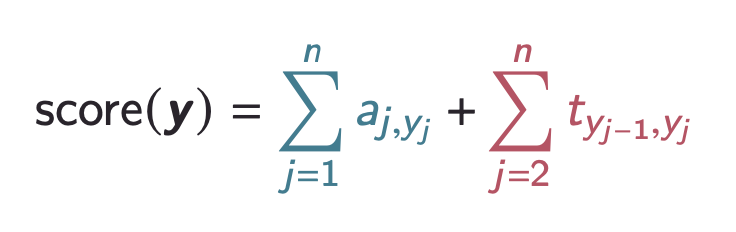

<i>

Hints:

* If you aren't sure where to start, first figure out how the first summation does, then figure the next one out.
* Do not be afraid of using for-loops to figure it out: you don't need to optimise everything the first time you write it.
* Take a look at the `j`'s and the various sub-scripts.

</i>


In [ ]:
# @title [Task] Implement `score_sequence`

def score_sequence(
    sequence: torch.Tensor, unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """
    Computes the total score for a given sequence of tags using unary and transition scores.

    Args:
        sequence (torch.Tensor): Tag sequence (indices ofc).
            Shape: [sequence_length]
        unary_scores (torch.Tensor): Unary scores for each tag at each position.
            Shape: [sequence_length, num_tags]
        transition_matrix (torch.Tensor): Transition scores between tags.
            Shape: [num_tags, num_tags]

    Returns:
        torch.Tensor: Scalar score of the POS sequence, like a loss value.

    Note:
        - POS tags are assumed to be represented as integers, where each integer
          corresponds to a specific tag in the model's vocabulary.
        - The unary_score_matrix and transition_matrix should be log-probabilities or
          unnormalized scores.
        - sequence_length: The length of the input sequence
        - num_tags: The total number of unique POS tags in the model's vocabulary
        - Assumes all tensors are already on the same device

    Example:
        >>> sequence = torch.tensor([0, 1, 2])
        >>> unary_scores = torch.randn(3, 5)  # 3 positions, 5 possible tags
        >>> transition_matrix = torch.randn(5, 5)  # Transition scores for 5 tags
        >>> total_score = score_sequence(sequence, unary_scores, transition_matrix)
    """
    sequence_length = sequence.size(0)

    # Select unary scores for the given tag sequence
    # Shape: [sequence_length, ]

    # pos_tag_sequence[:-1] == all tags except last one
    # pos_tag_sequence[1:] == all tags except first one
    # Shape: [num_tags, ]

    # Compute total score by summing all unary scores and transition scores together
    raise NotImplementedError


# See what happens when you run the below
sequence = torch.tensor([0, 1, 2])
unary_scores = torch.randn(3, 5)  # 3 positions, 5 possible tags
transition_matrix = torch.randn(5, 5)  # Transition scores for 5 tags
total_score = score_sequence(sequence, unary_scores, transition_matrix)

NameError: name 'torch' is not defined

In [ ]:
# @title [Solution] Implement `score_sequence`
import torch

def score_sequence(
    sequence: torch.Tensor, unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """
    Computes the total score for a given sequence of tags using unary and transition scores.

    Args:
        sequence (torch.Tensor): Tag sequence (indices ofc).
            Shape: [sequence_length]
        unary_scores (torch.Tensor): Unary scores for each tag at each position.
            Shape: [sequence_length, num_tags]
        transition_matrix (torch.Tensor): Transition scores between tags.
            Shape: [num_tags, num_tags]

    Returns:
        torch.Tensor: Scalar score of the POS sequence, like a loss value.

    Note:
        - POS tags are assumed to be represented as integers, where each integer
          corresponds to a specific tag in the model's vocabulary.
        - The unary_score_matrix and transition_matrix should be log-probabilities or
          unnormalized scores.
        - sequence_length: The length of the input sequence
        - num_tags: The total number of unique POS tags in the model's vocabulary
        - Assumes all tensors are already on the same device

    Example:
        >>> sequence = torch.tensor([0, 1, 2])
        >>> unary_scores = torch.randn(3, 5)  # 3 positions, 5 possible tags
        >>> transition_matrix = torch.randn(5, 5)  # Transition scores for 5 tags
        >>> total_score = score_sequence(sequence, unary_scores, transition_matrix)
    """
    sequence_length = sequence.size(0)

    # Select unary scores for the given tag sequence
    # Shape: [sequence_length, ]
    sequence_unary_scores = unary_scores[
        torch.arange(sequence_length, device=unary_scores.device), sequence
    ]

    # pos_tag_sequence[:-1] == all tags except last one
    # pos_tag_sequence[1:] == all tags except first one
    # Shape: [num_tags, ]
    sequence_transition_score = transition_matrix[sequence[:-1], sequence[1:]]

    # Compute total score by summing all unary scores and transition scores together
    total_score = sequence_unary_scores.sum() + sequence_transition_score.sum()
    return total_score



In [ ]:
# @title [Test] Implement `score_sequence`


%%ipytest -vv -p no:warnings

import pytest
import torch
from hypothesis import given, strategies as st, assume, settings, HealthCheck, example, Verbosity


tag_sequence_strategy = st.lists(st.integers(min_value=0, max_value=200), min_size=1, max_size=100)

@given(tag_sequence=tag_sequence_strategy)
@example([1,2,1])
@example([2,0,0])
def test_score_seq_returns_zero_with_zero_scores(tag_sequence: list[int]):
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    unary_scores = torch.zeros(sequence_length, num_pos_tags)
    transition_matrix = torch.zeros(num_pos_tags, num_pos_tags)

    tag_sequence_tensor=torch.tensor(tag_sequence, dtype=torch.long)

    output = score_sequence(tag_sequence_tensor, unary_scores, transition_matrix)
    assert output == 0


@given(tag_sequence=tag_sequence_strategy)
@example([1,2,1])
def test_score_seq_computes_unary_score_correctly(tag_sequence: list[int]):
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    unary_scores = torch.randn(sequence_length, num_pos_tags)
    transition_matrix = torch.zeros(num_pos_tags, num_pos_tags)

    tag_sequence_tensor=torch.tensor(tag_sequence, dtype=torch.long)

    output = score_sequence(tag_sequence_tensor, unary_scores, transition_matrix)
    expected = unary_scores[torch.arange(sequence_length),tag_sequence_tensor ].sum()
    assert torch.allclose(output, expected)

@given(tag_sequence=tag_sequence_strategy)
@settings(suppress_health_check=[HealthCheck.filter_too_much])
@example([1, 3, 1])
@example([1, 2, 1])
@example([1, 1, 2])
@example([0, 2, 1])
def test_score_seq_uses_transitions_correctly(tag_sequence: list[int]):
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    assume(num_pos_tags >= 3)
    assume(sequence_length >= 3)

    start_tag = tag_sequence[1]
    end_tag = tag_sequence[2]

    tag_sequence_tensor=torch.tensor(tag_sequence, dtype=torch.long)

    num_transitions = tag_sequence_tensor.unfold(0, 2, 1).eq(torch.tensor([start_tag,end_tag])).all(dim=1).sum() if tag_sequence_tensor.size(0) >= 2 else 0
    assume(num_transitions > 0)

    unary_scores = torch.zeros(sequence_length, num_pos_tags)
    transition_matrix = torch.zeros(num_pos_tags, num_pos_tags)

    transition_matrix[start_tag,end_tag] = 17
    output = score_sequence(tag_sequence_tensor, unary_scores, transition_matrix)
    assert output == 17 * num_transitions

@given(tag_sequence=tag_sequence_strategy)
@example([1, 3, 1])
@example([1, 2, 1])
@example([1, 1, 2])
@example([0, 2, 1])
def test_score_seq_with_one_transition(tag_sequence: list[int]):
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    unary_scores = torch.zeros(sequence_length, num_pos_tags)
    transition_matrix = torch.ones(num_pos_tags, num_pos_tags)

    tag_sequence_tensor=torch.tensor(tag_sequence, dtype=torch.long)

    output = score_sequence(tag_sequence_tensor, unary_scores, transition_matrix)

    assert output == tag_sequence_tensor.size(0) - 1

@given(tag_sequence=tag_sequence_strategy)
@example([1, 3, 1])
def test_score_sequence_allows_gradients(tag_sequence: list[int]):
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    assume(sequence_length > 1)

    unary_scores = torch.zeros(sequence_length, num_pos_tags, requires_grad=True)
    transition_matrix = torch.zeros(num_pos_tags, num_pos_tags, requires_grad=True)

    tag_sequence_tensor=torch.tensor(tag_sequence, dtype=torch.long)

    output = score_sequence(tag_sequence_tensor, unary_scores, transition_matrix)
    output.backward()

    assert unary_scores.grad is not None
    assert (unary_scores.grad**2).sum() > 0
    assert transition_matrix.grad is not None
    assert (transition_matrix.grad**2).sum() > 0


======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
hypothesis profile 'default' -> database=DirectoryBasedExampleDatabase(PosixPath('/content/.hypothesis/examples'))
rootdir: /content
plugins: hypothesis-6.112.1, anyio-3.7.1, typeguard-4.3.0
collecting ... collected 5 items

t_473be10ce92d4bb1ad5347c9cc0af463.py::test_score_seq_returns_zero_with_zero_scores PASSED   [ 20%]
t_473be10ce92d4bb1ad5347c9cc0af463.py::test_score_seq_computes_unary_score_correctly PASSED  [ 40%]
t_473be10ce92d4bb1ad5347c9cc0af463.py::test_score_seq_uses_transitions_correctly PASSED      [ 60%]
t_473be10ce92d4bb1ad5347c9cc0af463.py::test_score_seq_with_one_transition PASSED             [ 80%]
t_473be10ce92d4bb1ad5347c9cc0af463.py::test_score_sequence_allows_gradients PASSED           [100%]

======================================== 5 passed in 1.95s =========

<a name="normalizing"></a>


## Computing the normalizing constant

The log-normalizer computes the log of the sum of the exponentiated scores of all possible sequences. It ensures that the scores can be interpreted as probabilities, meaning that the probabilities of all possible sequences sum to one.

This is done with the forward algorithm, which we outline below:

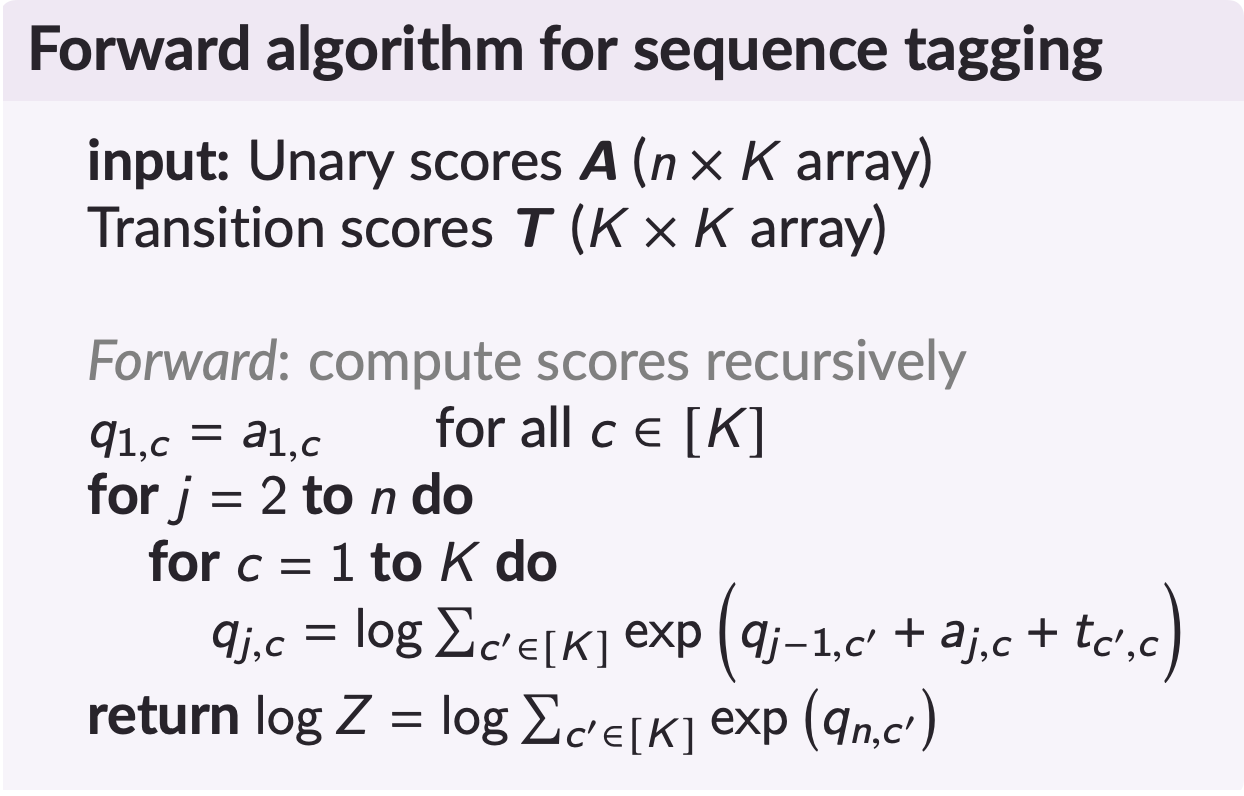

In [ ]:
# @title [Task] Implement `compute_normalizing_constant`

import torch


def compute_normalizing_constant(
    unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """Compute the normalizing constant for a sequence using unary and transition scores.

    Args:
        unary_scores (torch.Tensor): Unary scores for each tag at each position.
            Shape: [sequence_length, num_tags]
        transition_matrix (torch.Tensor): Transition scores between tags.
            Shape: [num_tags, num_tags]

    Returns:
        torch.Tensor: The computed normalizing constant, scalar

    Example:
        >>> unary_scores = torch.randn(3, 5)  # 3 positions, 5 possible tags
        >>> transition_matrix = torch.randn(5, 5)  # Transition scores for 5 tags
        >>> normalizing_constant = compute_normalizing_constant(unary_scores, transition_matrix)
    """
    # Number of positions (sequence_length) and number of tags (num_tags)

    # Initialize cumulative scores of zeros like unary scores. Shape: [sequence_length, num_tags]

    # The first position's cumulative scores are just the unary scores

    # Compute cumulative scores for each position
    for position in range(1, sequence_length):
        # Get the unary score for the current position

        # Get the cumulative score for the previous position

        # Add it all together with the transition matrix

        # LogSumExp and update the cumulative scores for the current position

    # Return the log-sum-exp of the last position's cumulative scores
    raise NotImplementedError()


# See what your code does
unary_scores = torch.randn(3, 5)  # 3 positions, 5 possible tags
transition_matrix = torch.randn(5, 5)  # Transition scores for 5 tags
normalizing_constant = compute_normalizing_constant(unary_scores, transition_matrix)

In [ ]:
# @title [SLOW Solution] Implement `compute_normalizing_constant`

import itertools
import torch


def compute_normalizing_constant(
    unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """Compute the normalizing constant for a sequence using unary and transition scores.

    Args:
        unary_scores (torch.Tensor): Unary scores for each tag at each position.
            Shape: [sequence_length, num_tags]
        transition_matrix (torch.Tensor): Transition scores between tags.
            Shape: [num_tags, num_tags]

    Returns:
        torch.Tensor: The computed normalizing constant, scalar

    Example:
        >>> unary_scores = torch.randn(3, 5)  # 3 positions, 5 possible tags
        >>> transition_matrix = torch.randn(5, 5)  # Transition scores for 5 tags
        >>> normalizing_constant = compute_normalizing_constant(unary_scores, transition_matrix)
    """
    # generate all possible combinations
    all_possible_combinations = itertools.product(range(num_tags), repeat=sequence_length)
    score_per_sequence = []

    # Compute the score for each sequence
    for seq in all_possible_combinations:
        seq = torch.tensor(seq, dtype=torch.long)
        # Use the score_sequence function to compute the score
        score = score_sequence(seq, unary_scores, transition_matrix)
        score_per_sequence.append(score)

    # Combine into a single tensor
    scores = torch.cat([score.unsqueeze(0) for score in score_per_sequence])

    # Do the logsumexp trick
    return torch.logsumexp(scores, dim=0)

In [ ]:
# @title [Solution] Implement `compute_normalizing_constant`

import torch

def compute_normalizing_constant(
    unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """Compute the normalizing constant for a sequence using unary and transition scores.

    Args:
        unary_scores (torch.Tensor): Unary scores for each tag at each position.
            Shape: [sequence_length, num_tags]
        transition_matrix (torch.Tensor): Transition scores between tags.
            Shape: [num_tags, num_tags]

    Returns:
        torch.Tensor: The computed normalizing constant, scalar

    Example:
        >>> unary_scores = torch.randn(3, 5)  # 3 positions, 5 possible tags
        >>> transition_matrix = torch.randn(5, 5)  # Transition scores for 5 tags
        >>> normalizing_constant = compute_normalizing_constant(unary_scores, transition_matrix)
    """
    # Number of positions (sequence_length) and number of tags (num_tags)
    sequence_length = unary_scores.size(0)

    # Initialize cumulative scores. Shape: [sequence_length, num_tags]
    cumulative_scores = torch.zeros_like(unary_scores)

    # The first position's cumulative scores are just the unary scores
    cumulative_scores[0, :] = unary_scores[0, :]

    # Compute cumulative scores for each position
    for position in range(1, sequence_length):
        # Compute the cumulative sum for the current position
        current_score = unary_scores[position, :]
        previous_cumulative_score = cumulative_scores[position - 1, :].unsqueeze(1)
        sum_scores = (
            current_score.unsqueeze(0) + transition_matrix + previous_cumulative_score
        )
        cumulative_scores[position, :] = torch.logsumexp(sum_scores, dim=0)

    # Return the log-sum-exp of the last position's cumulative scores
    return torch.logsumexp(cumulative_scores[-1], dim=0)

In [ ]:
# @title [Test] Implement `compute_normalizing_constant`

%%ipytest -vv --capture=tee-sys -p no:warnings

import pytest
import torch
from hypothesis import (
    given,
    strategies as st,
    assume,
    settings,
    HealthCheck,
    example,
    Verbosity,
)
from hypothesis.extra.numpy import arrays
import numpy as np
import itertools

@torch.inference_mode()
def compute_normalizing_constant_bruteforce(
    unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """Brute force a solution to compute the constant."""
    n, m = unary_scores.shape

    # generate all possible combinations
    seqs = itertools.product(np.arange(m), repeat=n)
    scores = []

    for seq in seqs:
        seq = torch.tensor(seq, dtype=torch.long)
        score = score_sequence(seq, unary_scores, transition_matrix)
        scores.append(score)

    scores = torch.cat([s.unsqueeze(0) for s in scores])
    return torch.logsumexp(scores, dim=0)



tag_sequence_strategy = st.lists(
    st.integers(min_value=0, max_value=5), min_size=1, max_size=5
)


@given(tag_sequence=tag_sequence_strategy)
@example([1, 2, 1])
@example([2, 0, 0])
def test_compute_normalizing_constant_with_zeros(tag_sequence: list[int]):
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    unary_scores = torch.zeros(sequence_length, num_pos_tags)
    transition_matrix = torch.zeros(num_pos_tags, num_pos_tags)

    output = compute_normalizing_constant(unary_scores, transition_matrix)
    expected = torch.tensor(num_pos_tags, dtype=torch.double).pow(sequence_length).log()

    torch.testing.assert_close(output, expected, check_dtype=False)

@given(tag_sequence=tag_sequence_strategy)
@example([1, 3, 1])
def test_compute_normalizing_constant_allows_gradients(tag_sequence: list[int]):
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    assume(sequence_length > 1)

    unary_scores = torch.zeros(sequence_length, num_pos_tags, requires_grad=True)
    transition_matrix = torch.zeros(num_pos_tags, num_pos_tags, requires_grad=True)

    output = compute_normalizing_constant(unary_scores, transition_matrix)
    output.backward()

    assert unary_scores.grad is not None
    assert (unary_scores.grad**2).sum() > 0
    assert transition_matrix.grad is not None
    assert (transition_matrix.grad**2).sum() > 0


@given(tag_sequence=tag_sequence_strategy)
@example([1, 2, 1])
@example([2, 0, 0])
@settings(max_examples=3)
def test_compute_normalizing_constant_works(tag_sequence: list[int]):
    """Compare with the brute force solution.

    Warning: this is so slow.
    """
    num_pos_tags: int = max(tag_sequence) + 1
    sequence_length: int = len(tag_sequence)

    unary_scores = torch.randn(sequence_length, num_pos_tags)
    transition_matrix = torch.randn(num_pos_tags, num_pos_tags)

    result = compute_normalizing_constant(unary_scores, transition_matrix)
    expected_result = compute_normalizing_constant_bruteforce(
        unary_scores, transition_matrix
    )
    torch.testing.assert_close(result, expected_result, check_dtype=False)

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
hypothesis profile 'default' -> database=DirectoryBasedExampleDatabase(PosixPath('/content/.hypothesis/examples'))
rootdir: /content
plugins: hypothesis-6.112.1, anyio-3.7.1, typeguard-4.3.0
collecting ... collected 3 items

t_473be10ce92d4bb1ad5347c9cc0af463.py::test_compute_normalizing_constant_with_zeros PASSED   [ 33%]
t_473be10ce92d4bb1ad5347c9cc0af463.py::test_compute_normalizing_constant_allows_gradients PASSED [ 66%]
t_473be10ce92d4bb1ad5347c9cc0af463.py::test_compute_normalizing_constant_works PASSED        [100%]

======================================== 3 passed in 0.83s =========================================


<a name="bestscoring"></a>

## Getting the best scoring sequence

To be able to perform inference with the model, we want to take the sequence and some unary scores and transitions, and then get the tag sequence with the best possible scores.

In [ ]:
# @title [Slow] Get the best scoring sequence

import itertools
import torch

def get_best_scoring_sequence(
    unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """Compute the best scoring sequence with given unary scores and transition matrix.

    Args:
        unary_scores (torch.Tensor): Unary scores for each tag at each position.
            Shape: [sequence_length, num_tags]
        transition_matrix (torch.Tensor): Transition scores between tags.
            Shape: [num_tags, num_tags]

    Returns:
        torch.Tensor: Sequence with the highest score
            Shape: [sequence_length]

    Example:
        >>> unary_scores = torch.tensor([[1.2, 0.1], [0.5, 1.1], [1.1, 0.3]])
        >>> transition_matrix = torch.tensor([[0.8, 0.2], [0.4, 0.7]])
        >>> get_best_scoring_sequence(unary_scores, transition_matrix)
        tensor([0, 1, 0])
    """
    sequence_length, num_tags = unary_scores.shape

    # generate all possible combinations
    all_possible_combinations = itertools.product(range(num_tags), repeat=sequence_length)
    score_per_sequence = []

    # Get the score for each sequence
    for seq in all_possible_sequences:
        seq = torch.tensor(seq, dtype=torch.long)
        score = score_sequence(seq, unary_scores, transition_matrix)
        score_per_sequence.append((score.item(), seq))

    # Rank the scores from best to worst
    score_per_sequence.sort(key=lambda x: x[0], reverse=True)
    # Return the best score
    return score_per_sequence[0][1]

In [ ]:
# @title [Faster] Get the best scoring sequence

def get_best_scoring_sequence(
    unary_scores: torch.Tensor, transition_matrix: torch.Tensor
) -> torch.Tensor:
    """Compute the best scoring sequence with given unary scores and transition matrix.

    Args:
        unary_scores (torch.Tensor): Unary scores for each tag at each position.
            Shape: [sequence_length, num_tags]
        transition_matrix (torch.Tensor): Transition scores between tags.
            Shape: [num_tags, num_tags]

    Returns:
        torch.Tensor: Sequence with the highest score
            Shape: [sequence_length]

    Example:
        >>> unary_scores = torch.tensor([[1.2, 0.1], [0.5, 1.1], [1.1, 0.3]])
        >>> transition_matrix = torch.tensor([[0.8, 0.2], [0.4, 0.7]])
        >>> get_best_scoring_sequence(unary_scores, transition_matrix)
        tensor([0, 1, 0])
    """
    sequence_length, num_tags = unary_scores.shape

    # Initialize cumulative score tensor
    cumulative_scores = torch.zeros_like(unary_scores)
    # Initialize backpointer tensor
    backpointers = -torch.ones(
        sequence_length, num_tags, device=unary_scores.device, dtype=torch.long
    )

    # Set initial scores to the first unary scores
    cumulative_scores[0, :] = unary_scores[0, :]

    # Fill cumulative_scores and backpointers
    for position in range(1, sequence_length):
        # Broadcast addition over previous scores and transitions
        scores_with_transitions = transition_matrix + cumulative_scores[
            position - 1, :
        ].unsqueeze(1)
        max_scores = torch.max(scores_with_transitions, dim=0)
        cumulative_scores[position, :] = unary_scores[position, :] + max_scores.values
        backpointers[position, :] = max_scores.indices

    # Trace back from the best endpoint to get the optimal sequence
    best_sequence = torch.zeros(
        sequence_length, dtype=torch.long, device=unary_scores.device
    )
    # Set the last value to the best score at the last step
    best_sequence[-1] = torch.argmax(cumulative_scores[-1])

    for position in range(sequence_length - 1, 0, -1):
        best_sequence[position - 1] = backpointers[position, best_sequence[position]]

    return best_sequence


<a name="trainstruct"></a>

## Training the Structured Sequence Prediction model

Once you've got the above sorted, now we can put it into a `torch.nn.Module` and train it! We've done this one for you but do take a good look at how the above functions are used.

In [ ]:
# @title Structured Tagger Model


class StructuredTaggerModel(TaggerModel):
    def __init__(
        self,
        model: torch.nn.Sequential,
        *,
        transition_matrix_regularization: float = 0.01,
    ) -> None:
        super().__init__(model=model)
        self.transition_matrix_regularization = transition_matrix_regularization

        self.transition_matrix = torch.nn.Parameter(
            torch.randn(self.num_output_features, self.num_output_features)
        )
        self.register_parameter("transition_matrix", self.transition_matrix)

    def compute_loss(
        self, unary_scores: torch.Tensor, targets: torch.Tensor
    ) -> torch.Tensor:
        # Score the predicted sequence
        true_score = score_sequence(targets, unary_scores, self.transition_matrix)
        # Compute the
        log_normalizer = compute_normalizing_constant(
            unary_scores, self.transition_matrix
        )
        loss = log_normalizer - true_score

        # Add regularization
        loss += self.transition_matrix_regularization * torch.sum(
            self.transition_matrix**2
        )
        return loss

    @torch.inference_mode()
    def predict_labels_from_unary_scores(
        self, unary_scores: torch.Tensor
    ) -> torch.Tensor:
        """Convert the predicted unary scores into labels."""
        return get_best_scoring_sequence(unary_scores, self.transition_matrix)


In [ ]:
# @title Train structured model

from torch.utils.data import DataLoader

# Some hyperparams
MAX_INSTANCES = 6000
EMBEDDING_DIM = 16
DROPOUT = 0.1

# Build the dataloaders for the train loop
train_dataloader = DataLoader(
    dataset["train"].select(range(MAX_INSTANCES)).with_format("torch"),
    batch_size=None,
    batch_sampler=None,
)
valid_dataloader = DataLoader(
    dataset["validation"].with_format("torch"), batch_size=None, batch_sampler=None
)

structured_model = StructuredTaggerModel(
    torch.nn.Sequential(
        torch.nn.Embedding(text_tokenizer.get_vocab_size(), EMBEDDING_DIM),
        torch.nn.Dropout(DROPOUT),
        torch.nn.Linear(EMBEDDING_DIM, upos_tokenizer.get_vocab_size() + 1),
    ),
    transition_matrix_regularization=0.01,
)

optimizer = torch.optim.Adam(structured_model.parameters(), lr=0.001)

train_model(
    model=structured_model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    total_epochs=10,
)


<a name="sec:speed"></a>

# Part 3. Speed vs Performance

By now you've noticed that this model is not the fastest to train. The big question is, are you leaving compute on the table?



Within Colab, if you are using a GPU, you can check the amount of RAM currently being utilised. It'll likely look something like this:


> 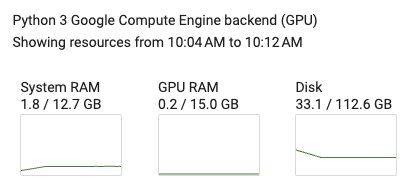




Currently (and in the solutions), the code is not optimised. Can you optimise your functions to reduce all the for-loops and improve the training speed?

How many instances per second can you do? What's the best? Without changing any hyperparameters, how does that affect training performance?

Things to try:

1. Support batching
2. Address inefficiencies within the various scoring functions



<a name="sec:arch"></a>

# Part 4. Comparing Architectures

As you will have seen, the structured model performs bettwe and trains faster, but is it the best we can do?

Below, we've copy-pasted the codeblock to train the unstructured model. Have a go with some different components in the core model and see what it does. For example, what would happen if you put an [RNN](https://pytorch.org/docs/stable/nn.html#recurrent-layers) or [CNN](https://pytorch.org/docs/stable/nn.html#convolution-layers) in it?  

<br/>

<b><u>Tip to keep using `torch.nn.Sequential`</u></b>

The [return of the RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) is not a single tensor, but in fact a tuple. To avoid implement a whole new `torch.nn.Module` to add the RNN, we can [register a forward hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook) that modifies the output of the forward so that it can directly be provided to the subsequent layers.

The implementation looks something like this:

```python
# Create the RNN for the model
rnn = torch.nn.GRU(EMBEDDING_DIM, EMBEDDING_DIM, num_layers=2, dropout=DROPOUT)
rnn.register_forward_hook(lambda module, args, output: output[0])

model = torch.nn.Sequential(..., rnn, ...)
```



In [ ]:
# @title Train unstructured model

from torch.utils.data import DataLoader

# Some hyperparams
MAX_INSTANCES = 6000
EMBEDDING_DIM = 16
DROPOUT = 0.1

# Build the dataloaders for the train loop
train_dataloader = DataLoader(
    dataset["train"].select(range(MAX_INSTANCES)).with_format("torch"),
    batch_size=None,
    batch_sampler=None,
)
valid_dataloader = DataLoader(
    dataset["validation"].with_format("torch"), batch_size=None, batch_sampler=None
)

rnn = torch.nn.GRU(EMBEDDING_DIM, EMBEDDING_DIM, num_layers=2, dropout=DROPOUT)
rnn.register_forward_hook(lambda module, args, output: output[0])

# And now the model
unstructured_model = UnstructuredTaggerModel(
    torch.nn.Sequential(
        torch.nn.Embedding(text_tokenizer.get_vocab_size(), EMBEDDING_DIM),
        rnn,
        torch.nn.Dropout(DROPOUT),
        torch.nn.Linear(EMBEDDING_DIM, upos_tokenizer.get_vocab_size() + 1),
    )
)

optimizer = torch.optim.Adam(unstructured_model.parameters(), lr=0.001)

train_model(
    model=unstructured_model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    total_epochs=10,
)
